# Libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [2]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)

<module 'rfdsppy.rf_tx_fw' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rf_tx_fw.py'>

# TxIIP2

In [7]:
TxIIP2 = 70 # dBm, at TRx input
TxPin = -8 # dBm at TRx input
RxPin = -80 # dBm at TRx input

# +3dB for peak power
AIIP2 = calc.dbm2v(TxIIP2+3, unit="dBm")
ATx = calc.dbm2v(TxPin+3, unit="dBm")

a1 = 1
a2 = 2*a1/AIIP2

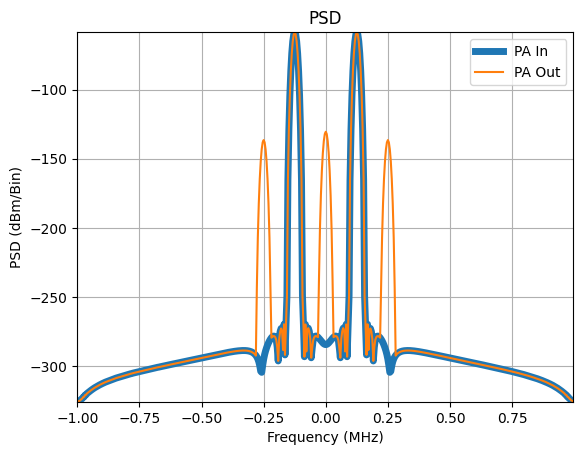

In [28]:
x = ATx*(np.exp(1j*np.pi/8*np.arange(2**12))+ np.exp(-1j*np.pi/8*np.arange(2**12)))
y = a1*x + 1/2*a2*(x*x.conjugate())

fs = 2
rbw = fs/2**9

py, f = calc.psd(y, fs, rbw)
px, _ = calc.psd(x, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), linewidth=5, label="PA In")
plt.plot(f, 10*np.log10(py), label="PA Out")
plt.title("PSD")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dBm/Bin)")
plt.xticks()
plt.yticks()
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

In [30]:
c1 = (y*np.exp(-1j*np.pi/8*np.arange(2**12))).sum().real # Tx power
c2 = (y*np.exp(-2j*np.pi/8*np.arange(2**12))).sum().real # IM2 power

print(f"Expected IM2 power (dBc) = {TxPin-TxIIP2}")
print(f"Measured IM2 power (dBc) = {20*np.log10(c2/c1)}")

Expected IM2 power (dBc) = -78
Measured IM2 power (dBc) = -78.00000000016021


In [58]:
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 4
wola = 1
rx_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, power=-80)
cfg = rx_wg.get_demod_params()
fs = cfg.get("fs")

tx_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=10*12, en_tprecode=en_tprecode, osr=osr, wola=wola, power=-12)

rx, rx_standard = rx_wg.generate(14)
tx, _ = tx_wg.generate(14)

y_tx = a1*tx + 1/2*a2*(tx*tx.conjugate())
y_rx = a1*rx + 1/2*a2*(rx*rx.conjugate())
y = y_tx+y_rx-tx

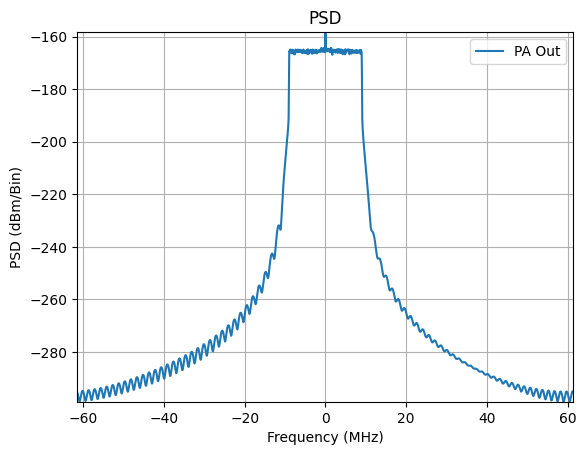

In [59]:
# Subtract tx from y_tx to get only the IM2

rbw = fs/2**12

py, f = calc.psd(y_tx-tx, fs, rbw)
py, f = calc.psd(y, fs, rbw)
# px, _ = calc.psd(tx, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
# plt.plot(f, 10*np.log10(px), linewidth=5, label="PA In")
plt.plot(f, 10*np.log10(py), label="PA Out")
plt.title("PSD")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dBm/Bin)")
plt.xticks()
plt.yticks()
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

EVM: 14.31%
SNR: 16.886702782404022


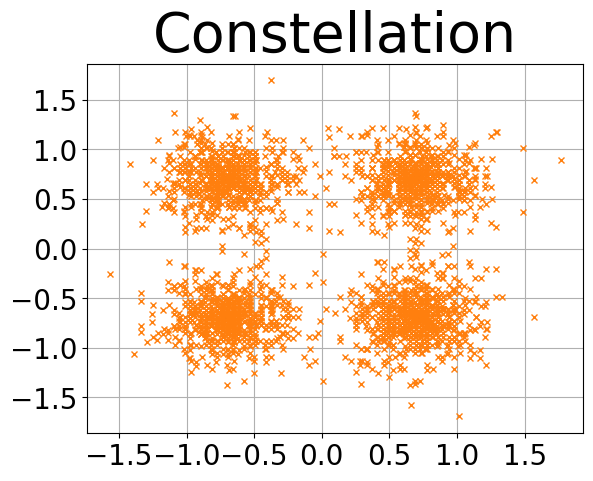

In [60]:
evm = rx_wg.calculate_evm(rx_standard, y[round(cfg["wola_len"]/2):]-y.mean(), en_plot=True, en_fd_eq=False)
print(f"EVM: {evm.round(2)}%")
print(f"SNR: {-20*np.log10(evm/100)}")

# IIP3

In [78]:
RxPin = -30 # dBm at eLNA input
IIP3 = (3*RxPin + 60)/2
# IIP3=0

# +3dB for peak power
AIIP3 = calc.dbm2v(IIP3+3, unit="dBm")
ARx = calc.dbm2v(RxPin+3, unit="dBm")

a1 = 1
a3 = -4/3*a1/AIIP3**2

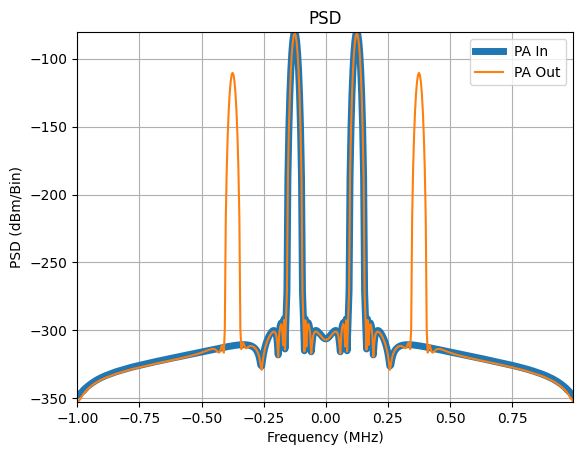

In [79]:
x = ARx*(np.exp(1j*np.pi/8*np.arange(2**12))+ np.exp(-1j*np.pi/8*np.arange(2**12)))
y = a1*x +3/4*a3*(x*x.conjugate())*x

fs = 2
rbw = fs/2**9

py, f = calc.psd(y, fs, rbw)
px, _ = calc.psd(x, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), linewidth=5, label="PA In")
plt.plot(f, 10*np.log10(py), label="PA Out")
plt.title("PSD")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dBm/Bin)")
plt.xticks()
plt.yticks()
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

In [ ]:
c1 = (y*np.exp(-1j*np.pi/8*np.arange(2**12))).sum().real # Rx power
c2 = (y*np.exp(-3j*np.pi/8*np.arange(2**12))).sum().real # IM3

# Some gain compression may happen
print(f"Expected IM3 power (dBc) = {2*RxPin - 2*IIP3}")
print(f"Measured IM3 power (dBc) = {20*np.log10(np.abs(c2/c1))}")

Expected IM3 power (dBc) = -30.0
Measured IM3 power (dBc) = -29.134235219012723


In [81]:
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 4
wola = 1
rx_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, power=-30)
cfg = rx_wg.get_demod_params()
fs = cfg.get("fs")

x, x_standard = rx_wg.generate(14)

y = a1*x +3/4*a3*(x*x.conjugate())*x

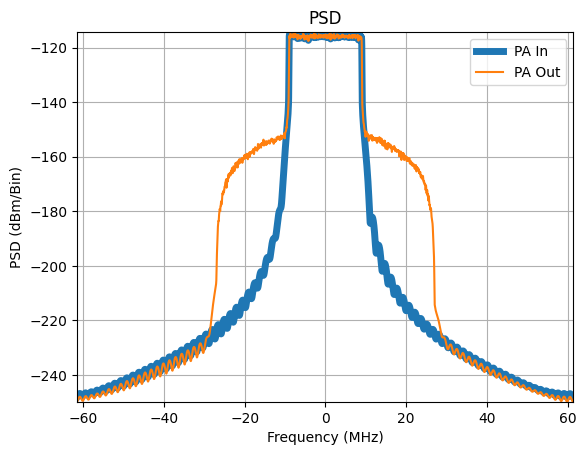

In [83]:
# Subtract tx from y_tx to get only the IM2

rbw = fs/2**12

py, f = calc.psd(y, fs, rbw)
px, f = calc.psd(x, fs, rbw)
# px, _ = calc.psd(tx, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), linewidth=5, label="PA In")
plt.plot(f, 10*np.log10(py), label="PA Out")
plt.title("PSD")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dBm/Bin)")
plt.xticks()
plt.yticks()
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

EVM: 2.07%
SNR: 33.699366564168656


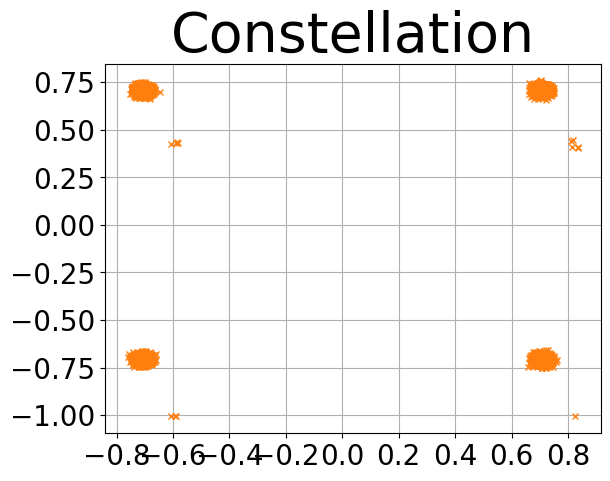

In [84]:
evm = rx_wg.calculate_evm(x_standard, y[round(cfg["wola_len"]/2):]-y.mean(), en_plot=True, en_fd_eq=False)
print(f"EVM: {evm.round(2)}%")
print(f"SNR: {-20*np.log10(evm/100)}")